<a href="https://colab.research.google.com/github/serigneka1/Project-ML/blob/main/XAI_Methodst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test Integrated Gradient Method

In [2]:
# !pip install -q xplique tensorflow


In [3]:
#!pip install -q xplique tensorflow

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
import cv2

import xplique
from xplique.plots import plot_attributions

from tensorflow import keras
import tensorflow.keras.applications as app

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from xplique.attributions import GradCAM,IntegratedGradients, SmoothGrad
import tensorflow.keras.applications as app

2025-03-25 08:30:57 URL:https://images.unsplash.com/photo-1615602127413-459bdb48cf45?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=phil-plante-X2PwqTUpXH8-unsplash.jpg&w=640 [78042/78042] -> "fox1.jpg" [1]


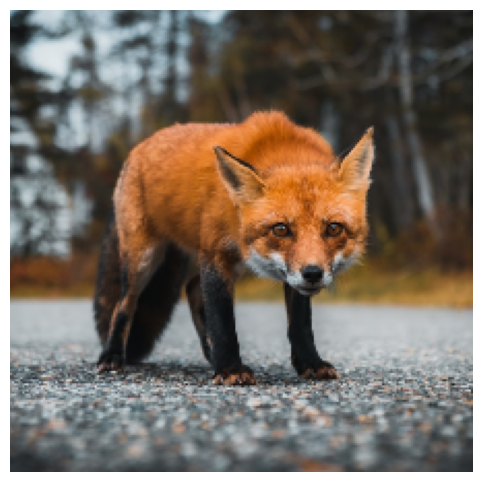

In [4]:
# downloading image from unsplash...
!wget -nv 'https://unsplash.com/photos/X2PwqTUpXH8/download?force=true&w=640' -O 'fox1.jpg'
# !wget -nv 'https://unsplash.com/photos/tIfrzHxhPYQ/download?force=true&w=640' -O 'fox2.jpg'
# !wget -nv 'https://unsplash.com/photos/LVnJlyfa7Zk/download?force=true&w=640' -O 'sea_turtle.jpg'
# !wget -nv 'https://unsplash.com/photos/sSEEbAzB6fU/download?force=true&w=640' -O 'lynx.jpg'
# !wget -nv 'https://unsplash.com/photos/41dAczoRYJY/download?force=true&w=640' -O 'cat.jpg'
# !wget -nv 'https://unsplash.com/photos/axqTLZ12Jss/download?force=true&w=640' -O 'otter.jpg'

img_list = [
    ('fox1.jpg', 277),
    # ('fox2.jpg', 277),
    # ('sea_turtle.jpg', 33),
    # ('lynx.jpg', 287),
    # ('cat.jpg', 281),
    # ('otter.jpg', 360)
]

def central_crop_and_resize(img, size=224):
  """
  given a numpy array, extracts the largest possible square and resizes it to the requested size
  """
  h, w, _ = img.shape

  min_side = min(h, w)
  max_side_center = max(h, w) // 2.0

  min_cut = int(max_side_center-min_side//2)
  max_cut = int(max_side_center+min_side//2)

  img = img[:, min_cut:max_cut] if w > h else img[min_cut:max_cut]
  img = tf.image.resize(img, (size, size))

  return img

X = []
Y = []

for img_name, label in img_list:
    img = cv2.imread(img_name)[..., ::-1] # when cv2 load an image, the channels are inversed
    img = central_crop_and_resize(img)
    label = tf.keras.utils.to_categorical(label, 1000)

    X.append(img)
    Y.append(label)

X = np.array(X, dtype=np.float32)
Y = np.array(Y)

plt.rcParams["figure.figsize"] = [15, 6]
for img_id, img in enumerate(X):
  plt.subplot(1, len(X), img_id+1)
  plt.imshow(img/255.0)
  plt.axis('off')

14536120/14536120 [==============================] - 0s 0us/step


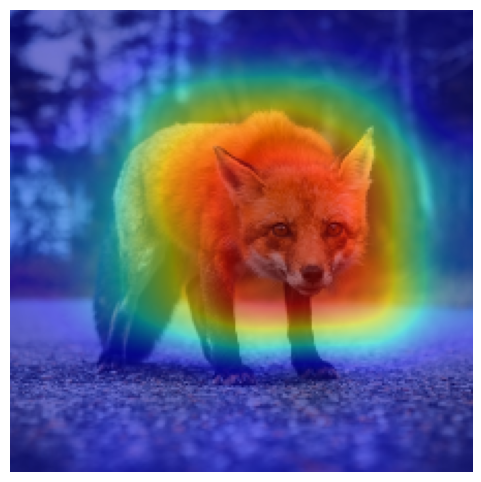

In [5]:
# load the model and preprocess the inputs (adapt the input range)
model, preprocessing = app.MobileNetV2(), app.mobilenet_v2.preprocess_input
X_preprocessed = preprocessing(np.array(X, copy=True))

# create an explainer and generate explanations
explainer_gradcam = GradCAM(model)
explanations_grad_cam = explainer_gradcam(X_preprocessed, Y) # `explainer.explain(inputs, labels)` also works

# plot the attribution on top of the image
for i in range(len(X)):
  plt.subplot(1, len(X), i+1)
  plt.imshow(X[i]/255.0)
  plt.imshow(explanations_grad_cam[i], cmap="jet", alpha=0.5)
  plt.axis('off')

Method: Saliency


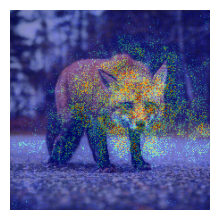



Method: GradientInput


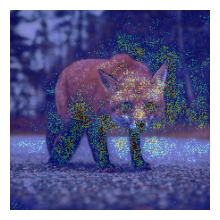



Method: IntegratedGradients


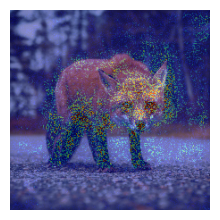



Method: SmoothGrad


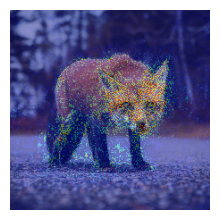



Method: VarGrad


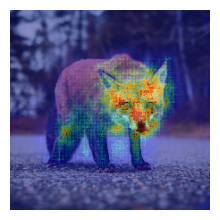



Method: SquareGrad


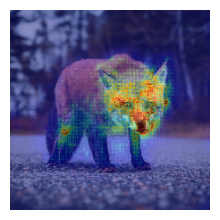



Method: GradCAM


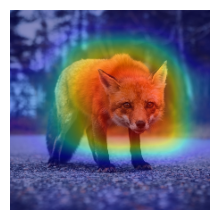



Method: Occlusion


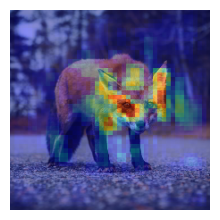



Method: Rise


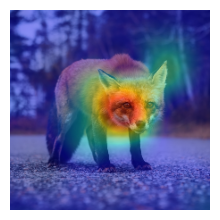



Method: GuidedBackprop


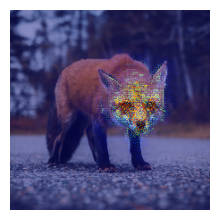



Method: GradCAMPP


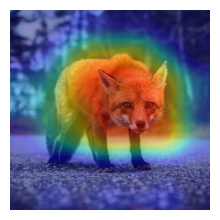

In [6]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop,
                                  GradCAMPP, Lime, KernelShap)

# to explain the logits is to explain the class,
# to explain the softmax is to explain why this class rather than another
# it is therefore recommended to explain the logit
model.layers[-1].activation = tf.keras.activations.linear
batch_size = 64


explainers_params = [
              (Saliency, {}),
              (GradientInput, {}),
              (IntegratedGradients, {"steps": 80}),
              (SmoothGrad, {"nb_samples": 80}),
              (VarGrad, {"nb_samples": 80}),
              (SquareGrad, {"nb_samples": 80}),
              (GradCAM, {}),
              (Occlusion, {"patch_size": 10, "patch_stride": 5}),
              (Rise, {"nb_samples": 4000}),
              (GuidedBackprop, {}),
              (GradCAMPP, {}),
              #(Lime, {"nb_samples": 1000}),
              #(KernelShap, {"nb_samples": 1000})
]

for explainer_class, params in explainers_params:

  explainer = explainer_class(model, batch_size=batch_size, **params)
  explanations = explainer(X_preprocessed, Y)

  print(f"Method: {explainer_class.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")